# Detecting pneumonia using chest x-rays

### To Do List

#### Research:
* CNNs
    * How do they work?
    * Idea of transfer learning
* Unique CNN implementations: AlexNet, CapsNet, GNN
    * What is unique about each of these implementations?
    
#### Implementation:
* Basic CNNs (PyTorch, tensorflow, keras)
* Transfer learning example
* Unique CNN implementations
* Understanding what the CNN found important (https://github.com/albermax/innvestigate)

#### Blog:
* Choosing a service (Medium, ...)

## Research

### Convolutional Neural Networks (CNNs)

CNNs are used for classifaction and computer vision. They are made up of three types of layers: convolutional, pooling, and fully-connected (FC). The first layer is a convolutional layer, and the last layer is the only fully-connected layer. The layers in between may be a mix of convolutional and pooling layers [1]. 

##### Convolutional Layers [1]
Convolutiuonal layers have an input, a filter (AKA kernel or feature detector), and a feature map. The feature detector is typically a 2D array of weights, which is applied to a subsection of the input. The dot product between this subsection and the kernel is then calculated. The filter then shifts by a stride, and performs the dot product operation once more, repeating this process until it has covered the entire input. The resulting array of outputs is called the feature map.

Some hyperparameters that can be adjusted in the convolutional layer are number of filters, stride, and zero padding. Number of filters affects the depth of the feature map (e.g. three filters results in a depth three feature map). Stride is the number of pixels the kernel moves after each dot product calculation. Zero padding refers to the amount of padding added to an input (eg. an image) to ensure that the filter fits the image.

After each convolution, the CNN applies a ReLU to introduce nonlinearities into the network, ensuring that the model is a universal approximator.

##### Pooling Layers [1]
Similar to a convolutional layer, except the filter does not use weights. Instead it implements a specific type of pooling: max pooling or average pooling. Max pooling is when the filter selects the pixel of maximum value to send to the output array. Average pooling is when the filter calculates the average value in the receptive field (the values that the filter can see).

More information is lost in pooling layers, but they "reduce complexity, improve efficiency, and limit risk of overfitting".

##### Fully-Connected Layer [1]
Usually uses a softmax activation function to make the final classification prediction.

### Residual Neural Networks (RNNs) [5]

RNNs are neural networks that include residual blocks. In residual blocks, layers feed directly into layers 2-3 layers deeper, while also still feeding into the next layer. These connections to deeper layers are called skip connections or residual connections. 

Generally the layers a NN solve for the true distribution H(x). However, the layers of a residual block solve for the residual! R(x) = Output - Input = H(x) - x => H(x) = R(x) + x. RNNs can also help with the problem of vanishing gradient by using skip connections to back propoagate larger gradients to earlier layers.

### Transfer Learning

Briefly introduced in class was the idea of transfer learning, whereby a previously trained neural network is used in a new problem. The ResNet50 network from PyTorch is a pretrained, RNN with 50 layers. ResNet50 is trained on images, and as such, early layers "learned" basic image features such as lines and shapes that can be used in any image classification problem. This saves an enormous amount of time and compute power, since those layers no longer need to be trained for new problems.

# Basic CNN Implementation

In [1]:
# Need to run with Python 3.6, Tensorflow 1.15, and Keras 2.2.4 for iNNvestigate

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2 # https://pypi.org/project/opencv-python/
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD
import os

import tensorflow
import keras

print(tensorflow.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.15.0
2.2.4


In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            if img == '.DS_Store' :
                continue
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
                
            except Exception as e:
                print(e)
                print (os.path.join(path, img))
                
    return np.array(data)

In [3]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
val = get_training_data('./chest_xray/val')

C:\Users\simoni\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


#### EDA (Exploratory Data Analysis) [2]

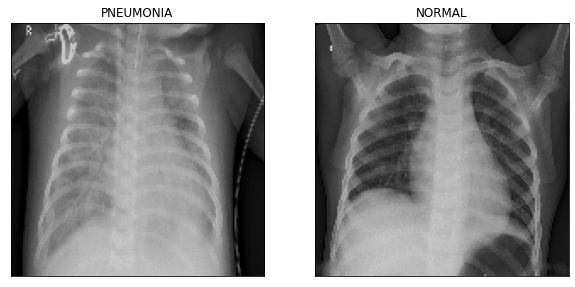

In [4]:
fig = plt.figure(figsize=(10,5))
a1 = fig.add_subplot(1,2,1)
plt.imshow(train[0][0], cmap='gray')
a1.set_title(labels[train[0][1]])
a1.set_xticks([])
a1.set_yticks([])

a2 = fig.add_subplot(1, 2, 2)
plt.imshow(train[-1][0], cmap='gray')
a2.set_title(labels[train[-1][1]])
a2.set_xticks([])
a2.set_yticks([])

plt.show()

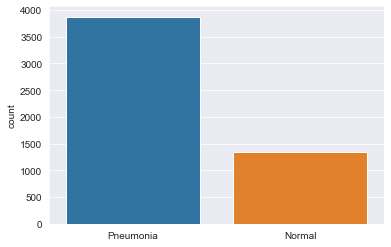

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append('Pneumonia')
    else:
        l.append('Normal')
        
sns.set_style('darkgrid')
sns.countplot(x=l)

plt.show()

#### Basic CNN Implementation [2]

In [6]:
# Preprocessing

x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in val:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [7]:
# Normalization

x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

In [8]:
# Resizing Data For CNN

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [9]:
# Produce Random Validation Set

indices = np.random.choice(len(x_train), round(0.2*len(x_train)), replace=False)
x_val = x_train[indices]
y_val = y_train[indices]
x_train = np.delete(x_train, indices, axis=0)
y_train = np.delete(y_train, indices, axis=0)

In [10]:
# Data Augmentation (Grayscales, Horizontal Flips, Vertical Flips, Random Crops, Color Jitters, Translations, Rotations, ...)
# Slightly alter the training data to increase the number of training examples and prevent overfitting

datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=30,
                             zoom_range=0.2,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False)

datagen.fit(x_train)

In [11]:
# https://faroit.com/keras-docs/2.1.2/models/about-keras-models/

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 64)        0         
___________________________________________________

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [13]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), epochs=10, steps_per_epoch = len(x_train) / 32,
                   validation_data=[x_val, y_val], callbacks=[learning_rate_reduction], shuffle=True)

model.save('./models/keras-cnn-t2.h5')



Epoch 1/10
131/130 [==============================] - 379s 3s/step - loss: 0.3240 - acc: 0.8637 - val_loss: 0.2138 - val_acc: 0.9350
Epoch 2/10
131/130 [==============================] - 375s 3s/step - loss: 0.2164 - acc: 0.9131 - val_loss: 0.2290 - val_acc: 0.9388
Epoch 3/10
131/130 [==============================] - 347s 3s/step - loss: 0.2029 - acc: 0.9152 - val_loss: 0.1842 - val_acc: 0.9369
Epoch 4/10
131/130 [==============================] - 341s 3s/step - loss: 0.1819 - acc: 0.9263 - val_loss: 0.8656 - val_acc: 0.7428

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/10
131/130 [==============================] - 380s 3s/step - loss: 0.1647 - acc: 0.9325 - val_loss: 0.3125 - val_acc: 0.8690
Epoch 6/10
131/130 [==============================] - 408s 3s/step - loss: 0.1632 - acc: 0.9348 - val_loss: 0.2018 - val_acc: 0.9111

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 7/10
131/130 [==================

In [17]:
model = load_model('./models/keras-cnn-t2.h5')

AttributeError: 'str' object has no attribute 'decode'

In [18]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 27s 44ms/step
Accuracy of the model is -  85.73717948717949 %


In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [21]:
y_prob = model.predict_proba(x_test)
y_pred = model.predict_classes(x_test)

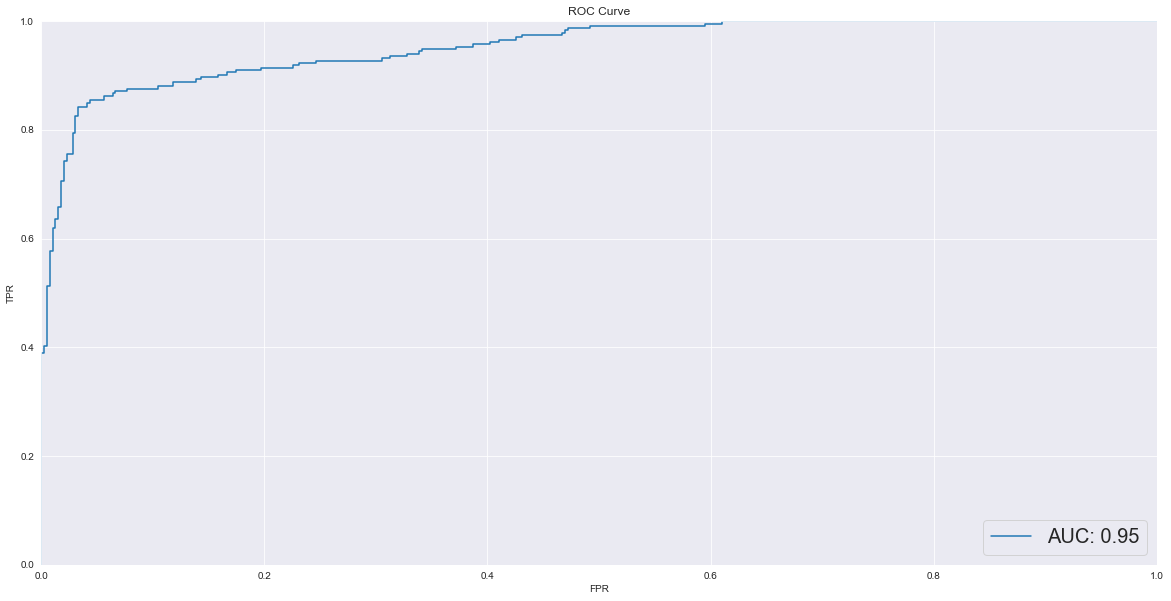

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(20,10))
plt.plot(fpr, tpr, label=f'AUC: {roc_auc_score(y_test, y_prob):.2f}')
plt.axis([0,1,0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right', prop={'size': 20})
plt.title('ROC Curve')
plt.show()

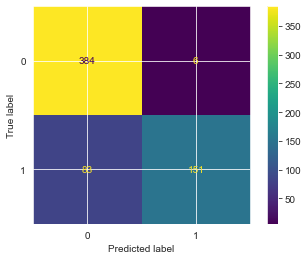

In [23]:
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()

# iNNvestigate [7]

In [25]:
import innvestigate
import innvestigate.applications.imagenet
import innvestigate.layers as ilayers
import innvestigate.utils as iutils
import innvestigate.utils.keras as kutils
import innvestigate.utils.keras.checks as kchecks
import innvestigate.utils.keras.graph as kgraph

innvestigate.__version__

'1.0.9'

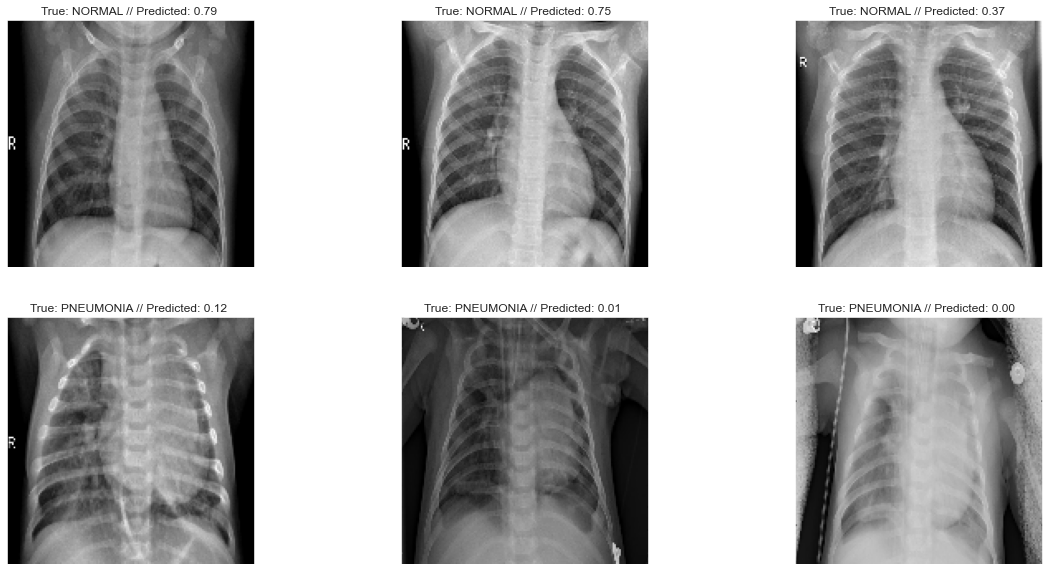

In [26]:
images = [x_test[i] for i in range(-3, 3)]
labels = ['NORMAL' if y_test[i] else 'PNEUMONIA' for i in range(-3, 3)]
predictions = [model.predict(x.reshape(1, 150, 150, 1))[0][0] for x in images]

fig, axs = plt.subplots(2, 3, figsize=(20,10))

for ax, im, l, p in zip(np.append(axs[0], axs[1]), images, labels, predictions):
    ax.imshow(im, cmap='gray')
    ax.set_title(f'True: {l} // Predicted: {p:.2f} ')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()    

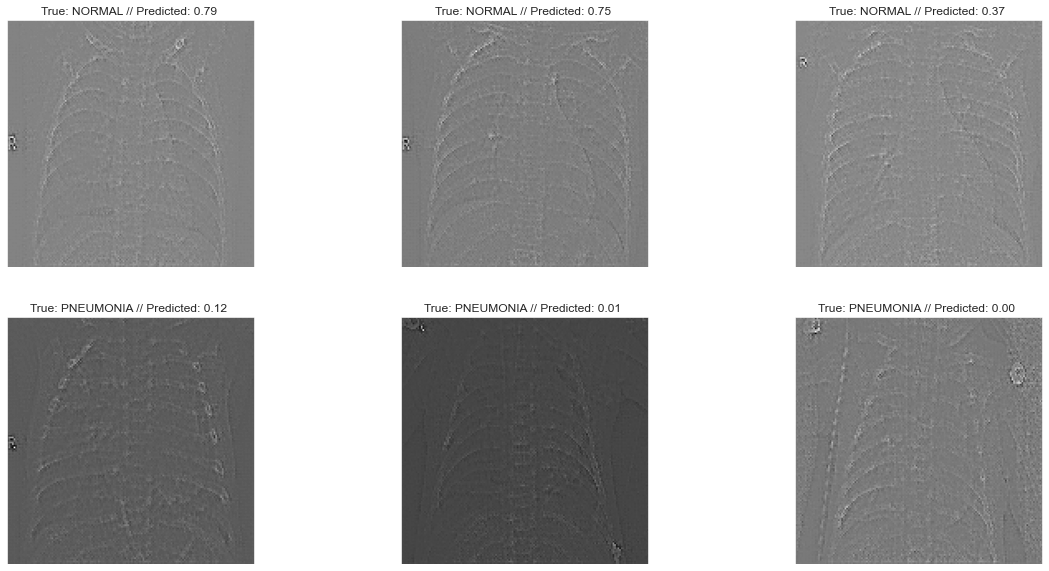

In [27]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer('guided_backprop', model)

fig, axs = plt.subplots(2, 3, figsize=(20,10))

for ax, im, l, p in zip(np.append(axs[0], axs[1]), images, labels, predictions):
    
    # Applying the analyzer
    analysis = gradient_analyzer.analyze(im.reshape(1, 150, 150, 1))
    
    ax.imshow(analysis.squeeze(), cmap='gray')
    ax.set_title(f'True: {l} // Predicted: {p:.2f} ')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show() 

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


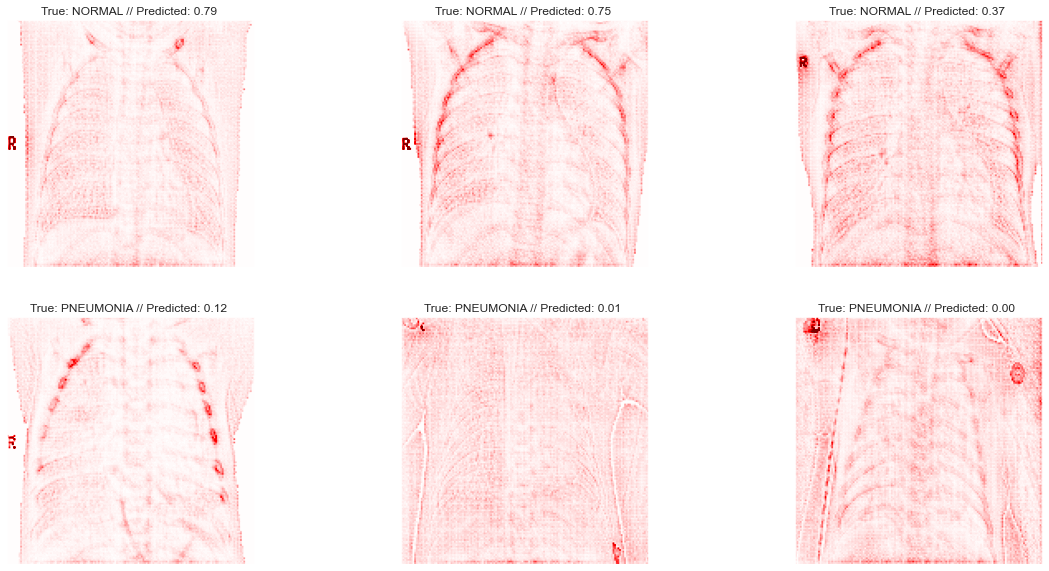

In [28]:
# Creating an analyzer
dt_analyzer = innvestigate.create_analyzer('deep_taylor', model)

fig, axs = plt.subplots(2, 3, figsize=(20,10))

for ax, im, l, p in zip(np.append(axs[0], axs[1]), images, labels, predictions):
    
    # Applying the analyzer
    a = dt_analyzer.analyze(im.reshape(1, 150, 150, 1))

    # Displaying the gradient
    a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
    a /= np.max(np.abs(a))
    # Plot
    ax.imshow(a, cmap="seismic", clim=(-0.3, 0.3))
    ax.set_title(f'True: {l} // Predicted: {p:.2f} ')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Transfer Learning with ResNet [4]

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'torch'

#### EDA [4]

In [ ]:
dataset = ImageFolder('./chest_xray/train',
                         transform=tt.Compose([tt.Resize(255),
                                               tt.CenterCrop(224),
                                               tt.RandomHorizontalFlip(),
                                               tt.RandomRotation(10),
                                               tt.RandomGrayscale(),
                                               tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                               tt.ToTensor()
                                              ]))

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
train_size = round(len(dataset)*0.7)
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [ ]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[0:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

#### Data Preprocessing [4]

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

In [ ]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds)), preds

#### Creating Model [4]

In [ ]:
class PneumoniaModelBase(nn.Module):
    
    def training_step(self, batch, weight):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels, weight=weight)
        acc, preds = accuracy(out, labels)
        
        return {'train_loss': loss, 'train_acc': acc}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc,preds = accuracy(out, labels)
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
        
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}   

In [ ]:
resnet50 = models.resnet50(pretrained=True)

In [ ]:
class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        for param in self.network.fc.parameters():
            param.require_grad = False
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, 2)
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, lr, model, train_loader, val_loader, weight, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = {}
    
    optimizer = opt_func(model.parameters(), lr)
    best_loss = 1
    for epoch in range(epochs):
        
        model.train()
        train_outputs = []
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']
            train_outputs.append(outputs)
            
            train_results = model.train_epoch_end(train_outputs)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
        val_results = evaluate(model, val_loader)
        if val_results['val_loss'] < best_loss and epoch + 1 > 15:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            
        model.epoch_end(epoch, train_results, val_results)
        
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
                
        model.load_state_dict(best_model_wts)
        
        return history, optimizer, best_loss

#### Training Model [4]

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = to_device(PneumoniaResnet(), device)

In [ ]:
epochs = 20
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
weight = torch.FloatTensor([3876/1342+3876, 1342/(1342+3876)]).to(device)

In [ ]:
# Had to run this on Kaggle since my GPU did not have enough memory

# history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight,
#                                     grad_clip=grad_clip,
#                                     weight_decay=weight_decay,
#                                     opt_func=opt_func)

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('./models/PneumoniaResnet.pth')

#### Evaluation [4]

In [ ]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [ ]:
test_dataset = ImageFolder('./chest_xray/test', 
                           transform=tt.Compose([tt.Resize(255),
                                                 tt.CenterCrop(224),                                                              
                                                 tt.ToTensor()
                                                ]))

In [ ]:
test_dl = DataLoader(test_dataset, batch_size=256)
# test_dl = DeviceDataLoader(test_dl, device)
preds,labels = test_predict(model, test_dl)

In [ ]:
cm = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()

# Experimenting with FastAI [6]

In [ ]:
from fastai.vision.all import *
from fastai.data.all import *
import numpy as np

In [ ]:
path = './chest_xray/train'
fnames = get_image_files(path)

def label_func(x): return x.parent.name

dls = ImageDataLoaders.from_path_func(path, fnames, label_func, item_tfms=Resize(224), bs=16, num_workers=0,
                                      batch_tfms=aug_transforms(pad_mode='zeros', max_warp=0, max_zoom=1)) 
dls.show_batch(max_n=9, figsize=(5,5))

In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=True)

learn.fit_one_cycle(1)

# CapsNet

In [ ]:
#Here is starting point I attempted, for text data not images
https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-capsule-networks

#Another starting point attempt
https://www.analyticsvidhya.com/blog/2018/04/essentials-of-deep-learning-getting-to-know-capsulenets/
    
#Here is a good library I fiddled with, should be possible to use with our dataset
https://github.com/naturomics/CapsLayer
    
#My next step was going to be this video + the code in description
https://www.youtube.com/watch?v=2Kawrd5szHE
    

In [30]:
# trying from .. https://www.kaggle.com/rodcardoso92/using-vgg-capsnet-to-diagnose-pneumonia/comments

from __future__ import print_function
from keras import backend as K
from keras import activations
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import regularizers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

IMG_SIZE = 299

In [31]:
def DataGenerator(train_batch, val_batch, IMG_SIZE):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255,
                                 rotation_range=10,
                                 horizontal_flip=True,
                                 vertical_flip=True)

    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

    train_gen = datagen.flow_from_directory('./chest_xray/train/',
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            color_mode='rgb', 
                                            class_mode='categorical',
                                            batch_size=train_batch)

    val_gen = datagen.flow_from_directory('./chest_xray/val/', 
                                          target_size=(IMG_SIZE, IMG_SIZE),
                                          color_mode='rgb', 
                                          class_mode='categorical',
                                          batch_size=val_batch)

    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255)
    
    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

    test_gen = datagen.flow_from_directory('./chest_xray/test/', 
                                           target_size=(IMG_SIZE, IMG_SIZE),
                                           color_mode='rgb', 
                                           class_mode='categorical',
                                           shuffle=False)
    
    return train_gen, val_gen, test_gen

In [32]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

In [33]:
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

In [46]:
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1 #default lambda 0.5 - but test with lambda with 0.9 - 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)

In [34]:
class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3, # Test number of routing with (1, 2, 3, 4) - Default = 3
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [35]:
train_batch = 32
val_batch = 1

train, val, test = DataGenerator(train_batch, val_batch, IMG_SIZE)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [52]:
input_image = Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# A InceptionResNetV2 Conv2D model
model = VGG16(include_top=False, weights='imagenet', input_tensor=input_image)
output = Conv2D(256, kernel_size=(9, 9), strides=(1, 1), activation='relu')(model.output)
x = Reshape((-1, 256))(output)
capsule = Capsule(2, 16, 4, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

In [53]:
lr=1e-4

checkpoint = ModelCheckpoint("weights.h5", 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='min')

early = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights=True)

callback_list = [checkpoint, early]

In [54]:
for i, layer in enumerate(model.layers):
    if i < 15:
        layer.trainable = False
    else:
        layer.trainable = True

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

In [49]:
epochs=1

model.compile(loss=margin_loss, optimizer=SGD(lr=lr, momentum=0.9), metrics=['accuracy'])

model.fit_generator(train,
                    epochs=epochs,
                    validation_data=val, 
                    validation_steps = len(val.classes)//val_batch,
                    steps_per_epoch=len(train.classes)//train_batch,
                    callbacks=callback_list)
    
loss, acc = model.evaluate_generator(test, len(test))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")

test.reset()

Epoch 1/100
163/163 [==============================] - 7488s 46s/step - loss: 0.1872 - acc: 0.8075 - val_loss: 0.3022 - val_acc: 0.6875

Epoch 00001: val_loss improved from inf to 0.30219, saving model to weights.h5
Epoch 2/100
  6/163 [>.............................] - ETA: 1:26:36 - loss: 0.0374 - acc: 0.9635

KeyboardInterrupt: 

# GNN

In [ ]:
#TODO (Ethan planning to work on this sunday morning)

## References

[1] https://www.ibm.com/cloud/learn/convolutional-neural-networks

[2] https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy

[3] https://data.mendeley.com/datasets/rscbjbr9sj/2 (THIS IS THE DATASET)

[4] https://www.kaggle.com/teyang/pneumonia-detection-resnets-pytorch

[5] https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

[6] https://course19.fast.ai/videos/?lesson=1

[7] Alber, M., Lapuschkin, S., Seegerer, P., Hägele, M., Schütt, K. T., Montavon, G., Samek, W., Müller, K. R., Dähne, S., & Kindermans, P. J. (2019). iNNvestigate neural networks! Journal of Machine Learning Research, 20.